In [1]:
from os.path import isfile
from os import listdir
from os.path import join as joinpath
from tqdm import tqdm

from src.wellClass import Well
from src.rkCorrection import gkCorrection, ngkCorrection
from src.rkCorrection import getNkPalleteValue


import numpy as np
import pandas as pd

In [2]:
folder = "las1"
filePaths = ([joinpath(folder, file) for file in listdir(folder) if (isfile(joinpath(folder, file))
             and file.lower().endswith('las'))])

data = pd.read_excel('Table.xlsx')

wells = [Well(filepath) for filepath in tqdm(filePaths[:])]


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:11<00:00,  1.84it/s]


In [3]:
name_wells_learn = ['2155', '2028', '2133', '2126', '2023', '2399', '2403', '2018', '2119', '2117', '2138', '1990',
                    '2401', '1963', '2128', '2156', '1899', '1933', '1956', '1982', '1985', '2010', '2026', '2032', 
                    '2102', '2115', '2116', '2118', '2121', '2122', '2123', '2124', '2135']

name_wells_test  = ['2134', '2137', '2111', '2151', '1968', '2110', '2259', '2341', '2398', '2261', '2400',
                    '2024', '2402', '2129', '1918', '2120']

In [4]:
wellData = {str(row["Well"]) : {"tops"  : (round(row['Top_C2vrT'], 1), round(row['Top_C2vrK'], 1), 
                                           round(row['Top_C2bsh'], 1), round(row['Bot_C2bsh'], 1)),
                                "dNom"        :  row['Dnom'],
                                "mudDens"     : row['Dens_BurR'],
                                "gkUnits"     : row['GKue'],
                                "ngkUnits"    : row['NGKue'],
                                "speed"       : row['Rk_Speed'],
                                "tau"         : row['Tau'],
                                "tool"        : str(row['RkTool_Type']),
                                "isNGK"       : row['Ngk_Type'],
                                "counterType" : row['CounterType'],
                                "alpha"       : row['Alpha'],
                                    }
            for i, row in data.iterrows()
           }
wells_learn = []
wells_test  = []
WELLS = []
for well in wells:
    try:
        if not "PZ" in well.curves.keys():
            print(well.name, "No PZ;")
            continue
        if not "GK" in well.curves.keys():
            print(well.name, "No GK;")
            continue
        if not "NGK" in well.curves.keys():
            print(well.name, "No NGK;")
            continue
        if not "BK" in well.curves.keys():
            print(well.name, "No BK; learn")
            continue
        if not "IK" in well.curves.keys():
            print(well.name, "No IK; learn")
            continue
        well.tops = wellData[well.name]["tops"]
        well.wellData = wellData[well.name]
        
        if "DS" not in well.curves.keys():
            well.wellData["haveDS"] = False
            well.curves["DS"] = 0.216 * np.ones(np.shape(well.curves["DEPT"]))
        else:
            well.wellData["haveDS"] = True
        #        
        #if well.name in name_wells_learn:
        #    wells_learn.append(well)
        #if well.name in name_wells_test:
        #    wells_test.append(well)
            
        WELLS.append(well)
        
    except:
        print("learn", well.name)
wells_learn = WELLS[:-10]        
wells_test = WELLS[-20:]
print("LEN_WELLS:", len(WELLS))
print("LEN_WELLS_LEARN:", len(wells_learn))
print("LEN_WELLS_TEST:", len(wells_test))

2074 No PZ;
2104 No PZ;
LEN_WELLS: 76
LEN_WELLS_LEARN: 66
LEN_WELLS_TEST: 20


In [5]:
DEPT_names = ["dept", "md", "депт", "глубина", "мд"]
DS_names = ["ds", "дс", "ds:1", "дс:1", "ds1", "дс1"]
PS_names = ['ps','ps:1','пс']
PZ_names = ["ks", "кс", "пз", "pz"]
GK_names = ["gr", "gr:1", "gr1", "гк", "гк:1", "гк1", "gk", "gk:1", "gk1"]

NK_names = ["ngk", "ngk:1", "ngk1", "ngl", "ngl:1", "ngl1", "нгк", 
            "нгк:1", "нгк1", "nkdt", "nkdt:1", "nkdt1", "jb", "jb:1", "jb1", 
            "jm", "jm:1", "jm1", "nk", "нк"]

IK_names = ["ik", "ik:1", "ik1", "ик", "ик:1", "ик1"]
BK_names = ["bk", "bk:1", "bk1", "бк", "бк:1", "бк1"]
LITO_names = ["lito", "кхрнкнцхъ", "litology", "литология", "лито"]
COLL_names = ["коллектор", "колл", "coll", "йнккейрнп"]
SATU_names = ["насыщение",'мюяшыемхе', "saturation", "satur", "насыщенность"]

In [6]:
def curve_push_in_wells(wells):
    for well in tqdm(wells):
        DEPT_bool = False
        for name in well.curves.keys():
            if name.lower() in DEPT_names:
                well.curves["DEPT"] = well.curves[name]
                DEPT_bool = True
                break
            else:
                pass
                
        DS_bool = False
        for name in well.curves.keys():
            if name.lower() in DS_names:
                well.curves["DS"] = well.curves[name]
                if np.nanmean(well.curves["DS"]) > 10:
                    well.curves["DS"] /= 1000
                DS_bool = True
                break
            else:
                pass
                
        PZ_bool = False
        for name in well.curves.keys():
            if name.lower() in PZ_names:
                well.curves["PZ"] = well.curves[name]
                PZ_bool = True
                break
            else:
                pass
                
                
        GK_bool = False
        for name in well.curves.keys():
            if name.lower() in GK_names:
                well.curves["GK"] = well.curves[name]
                GK_bool = True
                break
            else:
                pass
                
        NGK_bool = False
        for name in well.curves.keys():
            if name.lower() in NK_names:
                well.curves["NGK"] = well.curves[name]
                NGK_bool = True
                break
            else:
                pass
                
        PS_bool = False
        for name in well.curves.keys():
            if name.lower() in PS_names:
                well.curves["PS"] = well.curves[name]
                PS_bool = True
                break
            else:
                pass
                
        IK_bool = False
        for name in well.curves.keys():
            if name.lower() in IK_names:
                well.curves["IK"] = well.curves[name]
                IK_bool = True
                break
            else:
                pass
                
        BK_bool = False
        for name in well.curves.keys():
            if name.lower() in BK_names:
                well.curves["BK"] = well.curves[name]
                BK_bool = True
                break
            else:
                pass
                
        COLL_bool = False
        for name in well.curves.keys():
            if name.lower() in COLL_names:
                well.curves["COLLECTOR"] = well.curves[name]
                COLL_bool = True
                break
            else:
                pass
                
        SATU_bool = False
        for name in well.curves.keys():
            if name.lower() in SATU_names:
                well.curves["SATURATION"] = well.curves[name]
                SATU_bool = True
                break
            else:
                pass
        LITO_bool = False
        for name in well.curves.keys():
            if name.lower() in LITO_names:
                well.curves["LITOLOGY"] = well.curves[name]
                break
            else:
                pass
        if((GK_bool==False) or (NGK_bool == False)):
            print("not GK or NGK", well.name)
            wells.remove(well)        

In [7]:
curve_push_in_wells(wells_learn)
curve_push_in_wells(wells_test)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2858.52it/s]


In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [9]:
def CalculationNormRK(well):
    def Calc_Phi(ag, ang, c_type, horizont):
        poro = np.zeros(ag.shape)
        if horizont == "vr":
            a = 0.285
            b = 2.811
            c = 0.2
            d = 1.355
        elif horizont == "bash":
            a = 0.333
            b = 3.36
            c = 0.28
            d = 1.12
        poro = a * np.exp(-b * ang) - c * ag ** d
        poro[poro < 0] = 0
        return poro

    def Calc_S_oil(phi, ag, Rp, horizont):
        So = np.zeros(ag.shape)
        if horizont == "vr":
            a =  0.24
            b =  1.07
            c =  0.59
            Rw = 0.055
        elif horizont == "bash":
            a = 0.31
            b = 1.01
            c = 0.53
            Rw = 0.05
        So = 1 - a / (Rp**c*phi**b) 
        So[So < 0] = 0
        So[So > 1] = 1
        return  So
    
    
    
    def supports_gk(d, gk, tops):
        ind = np.logical_and(d > tops[0], d < tops[1])
        amin = np.nanmin(gk[ind])
        amax = np.nanmax(gk[ind])
        gk_rem = (gk[ind] - amin) / (amax - amin)
        GKmax_mid = (np.nanmean(gk_rem) + 1.244 * np.nanmax(gk_rem)) / 2
        GKmax = GKmax_mid * (amax - amin) + amin
        ########
        try:
            ind = np.logical_and(d > tops[2], d < tops[3])
            amin = np.nanmin(gk[ind])
            amax = np.nanmax(gk[ind])
            gk_rem = (gk[ind] - amin) / (amax - amin)
            GKmin_mid = (1.202 * np.nanmean(gk_rem) + np.nanmin(gk_rem)) / 2
            GKmin = GKmin_mid * (amax - amin) + amin
        except:
            GKmin = np.nanmin(gk)
            
        return GKmin, GKmax
    
    def supports_nk(d, nk, tops):
        ind = np.logical_and(d > tops[0], d < tops[1])
        amin = np.nanmin(nk[ind])
        amax = np.nanmax(nk[ind])
        nk_rem = (nk[ind] - amin) / (amax - amin)
        NKmin_mid = (0.516 * np.nanmean(nk_rem) + np.nanmin(nk_rem)) / 2  #0.256
        NKmin = NKmin_mid * (amax - amin) + amin
        try:
            mid = (tops[2]+tops[3]) / 2
            ind = np.logical_and(d > mid, d < tops[3])
            NKmax1 = (np.nanmean(nk[ind]) + 6.75*np.nanmax(nk[ind])) / 8
            ind = np.logical_and(d > tops[2], d < mid)
            NKmax2 = (np.nanmean(nk[ind]) + 6.75*np.nanmax(nk[ind])) / 8
            NKmax = max(NKmax1, NKmax2)
        except:
            NKmax = np.nanmax(nk)
            
        return NKmin, NKmax
    
    
    
    #try:
    ind_vr = np.logical_and(well.curves["DEPT"] > well.tops[0],
                            well.curves["DEPT"] <= well.tops[2])
    ind_bash = np.logical_and(well.curves["DEPT"] > well.tops[2],
                             well.curves["DEPT"] <= well.tops[3])
    
    well.curves['Kp_auto']   = np.nan*np.ones(np.shape(well.curves["DEPT"]))
    well.curves['Soil_auto'] = np.nan*np.ones(np.shape(well.curves["DEPT"]))

    if "IK" not in well.curves.keys():
        RP = well.curves["PZ"]
    else:
        RP = well.curves["IK"]

    gkCorrected, gkCorrectedAp = gkCorrection(well.curves['DEPT'],
                                              well.curves['GK'], np.copy(well.curves['DS']), well.wellData['dNom'],
                                              well.wellData['speed'], well.wellData['tau'], well.wellData['mudDens'])
    
    if not well.wellData["haveDS"]:
        gkCorrected = gkCorrectedAp
    
    well.curves["GKstd_auto"] = gkCorrected
    well.curves["GKstd_auto"][well.curves["GKstd_auto"] < 0] = 0
    
    ngkCorrected, ngkCorrectedAp = ngkCorrection(well.curves['DEPT'],
                                                 well.curves['NGK'], well.curves['GK'], np.copy(well.curves['DS']),
                                                 well.wellData['speed'], well.wellData['tau'], well.wellData['gkUnits'],
                                                 well.wellData['ngkUnits'], well.wellData['alpha'], well.wellData['dNom'],
                                                 well.wellData['tool'], well.wellData['isNGK'])
    if not well.wellData["haveDS"]:
        ngkCorrected = ngkCorrectedAp
    
    well.curves["NGKap_auto"] = ngkCorrectedAp #ngkCorrected
    well.curves["NGKap_auto"][well.curves["NGKap_auto"] < 0] = 0
    well.curves["GKap_auto"] = gkCorrectedAp
    #####
    sups = []
    sups = supports_gk(well.curves['DEPT'], well.curves['GKstd_auto'], well.tops)
    asupps_gk = [sups[0], sups[1]]
    well.asupps_gk = [sups[0], sups[1]]
    #####
    sups = []
    sups = supports_nk(well.curves['DEPT'], well.curves['NGKap_auto'], well.tops)
    asupps_nk = [sups[0], sups[1]]
    well.asupps_nk = [sups[0], sups[1]]
    #####
    well.curves["AG_auto"] = (well.curves["GK"]  - asupps_gk[0]) / (asupps_gk[1] - asupps_gk[0])
    well.curves["ANG_auto"] = (well.curves["NGK"] - asupps_nk[0]) / (asupps_nk[1] - asupps_nk[0])
    well.curves["Cavern"] = well.curves["DS"]- well.wellData['dNom']
    
    if well.wellData["haveDS"]:
        well.curves["H_ClayCrust"] = (well.wellData["dNom"] - well.curves["DS"]) / 2
        well.curves["H_ClayCrust"][well.curves["H_ClayCrust"] < 0] = 0
    
    well.curves["NK_min"] = np.ones(np.shape(well.curves["DEPT"])) * well.asupps_nk[0]
    well.curves["NK_max"] = np.ones(np.shape(well.curves["DEPT"])) * well.asupps_nk[1]
    well.curves["GK_min"] = np.ones(np.shape(well.curves["DEPT"])) * well.asupps_gk[0]
    well.curves["GK_max"] = np.ones(np.shape(well.curves["DEPT"])) * well.asupps_gk[1]
    
    well.curves['Kp_auto'][ind_vr] = Calc_Phi(well.curves["AG_auto"][ind_vr],
                                               well.curves["ANG_auto"][ind_vr],
                                               well.wellData["counterType"], "vr")
    
    well.curves['Kp_auto'][ind_bash] = Calc_Phi(well.curves["AG_auto"][ind_bash],
                                               well.curves["ANG_auto"][ind_bash],
                                               well.wellData["counterType"], "bash")

    well.curves['Soil_auto'][ind_vr] = Calc_S_oil(well.curves['Kp_auto'][ind_vr],
                                                  well.curves["AG_auto"][ind_vr],
                                                  RP[ind_vr], "vr")
    
    well.curves['Soil_auto'][ind_bash] = Calc_S_oil(well.curves['Kp_auto'][ind_bash],
                                                   well.curves["AG_auto"][ind_bash],
                                                   RP[ind_bash], "bash")
    
    well.curves["Kgl"] = well.curves["AG_auto"] * well.curves["AG_auto"]

In [10]:
for well in tqdm(wells_learn):
    CalculationNormRK(well)
for well in tqdm(wells_test):
    CalculationNormRK(well)

  0%|                                                                                           | 0/66 [00:00<?, ?it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in less
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
C:\Programs\anaconda

In [11]:
from scipy.signal import savgol_filter

def segmentation(well, name, span_smooth, smooth_iterations, h, top, bot):
    def FindLocalMins(crv, dept):
        gkmins = []
        for i in range (1, len(crv)-1):
            if ((crv[i-1] - crv[i]) >= 0 and (crv[i+1] - crv[i]) > 0) or ((crv[i-1] - crv[i]) > 0 and (crv[i+1] - crv[i]) >= 0):
                gkmins.append(dept[i])
        return gkmins

    def FindLocalMaxs(crv, dept):
        ngkmins = []
        for i in range (1, len(crv)-1):
            if ((crv[i-1] - crv[i]) <= 0 and (crv[i+1] - crv[i]) < 0) or ((crv[i-1] - crv[i]) < 0 and (crv[i+1] - crv[i]) <= 0):
                ngkmins.append(dept[i])
        return ngkmins
    
    dInd = np.logical_and(well.curves["DEPT"] >= top, well.curves["DEPT"] <= bot)
    
    d = well.curves["DEPT"][dInd]
    
    crv = np.copy(well.curves[name][dInd])
    
    for repeat in range(0, smooth_iterations):
        crv = savgol_filter(crv, span_smooth, 2, mode='nearest')     
    
    well.curves[name + "_sm"] = np.zeros(np.size(well.curves["DEPT"]))
    well.curves[name + "_sm"][:] = np.NaN
    well.curves[name + "_sm"][dInd] = crv
    
    mins = FindLocalMins(crv, d)
    maxs = FindLocalMaxs(crv, d)
    
    extrems = np.hstack((top, mins, maxs, bot))
    extrems.sort()
    
    boundaries = []
    
    for i in range(1, len(extrems)-2):
        
        d = well.curves["DEPT"][dInd]
        crv = np.copy(well.curves[name+"_sm"][dInd])
        
        crvAvg = (crv[d == extrems[i]] + crv[d == extrems[i+1]]) / 2
        
        dx = d[(d >= extrems[i])&(d <= extrems[i+1])]
        
        v1 = dx[crv[(d >= extrems[i])&(d <= extrems[i+1])] <= crvAvg][0]
        v2 = dx[crv[(d >= extrems[i])&(d <= extrems[i+1])] <= crvAvg][-1]
        
        if abs(crv[d == v1] - crvAvg) < abs(crv[d == v2] - crvAvg):   
            boundaries.append(v1)
        else:
            boundaries.append(v2)
            
    segs = np.hstack((top, boundaries, bot))
    segs.sort() 

    return segs

def MakeSegs(well, name, span_smooth, smooth_iterations, A, B):
    curves = well.curves
    
    #well.boundaries = {}
    
    for name in [name]:
        well.boundaries.update({name: segmentation(well, name, span_smooth, smooth_iterations, 0.5, A - 5, B + 5)})

    for name in [name]:
        
        bnd = well.boundaries[name]
        
        try:
            if not np.isfinite(curves[name+"_sm"][curves["DEPT"] >= bnd[-1]][0]):
                bnd[-1] = curves["DEPT"][np.isfinite(curves[name+"_sm"])][-2]
        except:
            bnd[-1] = curves["DEPT"][np.isfinite(curves[name+"_sm"])][-2]
        try:
            if not np.isfinite(curves[name+"_sm"][curves["DEPT"] <= bnd[0]][-1]):
                bnd[0] = curves["DEPT"][np.isfinite(curves[name+"_sm"])][2]
        except:
            bnd[0] = curves["DEPT"][np.isfinite(curves[name+"_sm"])][2]
            
        goUP = [0]
        if (curves[name + "_sm"][curves["DEPT"] > bnd [1]][0] - \
            curves[name + "_sm"][curves["DEPT"] <= bnd[1]][-1] >= 0):
            goUP[-1] = False
        else:
            goUP[-1] = True
            
        for i in range(1, len(well.boundaries[name])-1):
            right_grad = np.abs(curves[name + "_sm"][curves["DEPT"] > bnd[i+1]][0] - \
                                curves[name + "_sm"][curves["DEPT"] < bnd[i+1]][-1])
            left_grad = np.abs(curves[name + "_sm"][curves["DEPT"] > bnd[i]][0] - curves[
                    name + "_sm"][curves["DEPT"] < bnd[i]][-1])
            
            if right_grad > left_grad:
                if (curves[name + "_sm"][curves["DEPT"] > bnd[i+1]][0] - \
                    curves[name + "_sm"][curves["DEPT"] < bnd[i+1]][-1] <= 0):
                    goUP.append(True)
                else:
                    goUP.append(False)
            else:
                if (curves[name + "_sm"][curves["DEPT"] > bnd[i]][0] - \
                    curves[name + "_sm"][curves["DEPT"] < bnd[i]][-1] <= 0):
                    goUP.append(False)
                else:
                    goUP.append(True)

        if (curves[name + "_sm"][curves["DEPT"] > bnd[-2]][0] - \
            curves[name + "_sm"][curves["DEPT"] <= bnd[-2]][-1] >= 0):
            goUP[-1] = True
        else:
            goUP[-1] = False

        curves[name + "_ups"] = np.zeros(np.shape(well.curves["DEPT"]), dtype=bool)
        curves[name + "_seg"] = np.copy(curves[name])
        
        for i in range(len(well.boundaries[name])-1):
            seg_ind = np.logical_and(curves["DEPT"] >= bnd[i],
                                     curves["DEPT"] <= bnd[i+1])
            avg = np.nanmean(curves[name][seg_ind])
            min_max = [np.nanmin(curves[name][seg_ind]), np.nanmax(curves[name][seg_ind])]

            curves[name + "_ups"][seg_ind] = goUP[i]
            curves[name + "_seg"][seg_ind] = np.nanmean((avg + 3*min_max[goUP[i]])/4)


In [12]:
import copy
import scipy.stats as st

def reconstr(crv, dpt, cand):
    res = np.ones(len(crv)) * np.nan
    for c in cand:
        i0 = c[0]
        i1 = c[1]
        val = st.mode(crv[i0 : i1])[0][0]
        res[i0 : i1+1] = val
    return res

def CalculationNewMesh(WELLS_i):
    def GetCand(_bnd, dpt, tops):
        cand = []
        bnd = list(set(_bnd))
        bnd.append(tops[1])
        bnd.append(tops[3])
        bnd = np.sort(bnd)
        bnd = bnd[np.logical_and(bnd >= tops[1], bnd <= tops[3])]
        i = 0
        while i < len(bnd)-1:
            il = np.where(abs(dpt - bnd[i])   < 1e-3)[0][0]
            ir = np.where(abs(dpt - bnd[i+1]) < 1e-3)[0][0]
            cand.append([il, ir])
            i += 1
        res = []
        if abs(cand[0][0] - cand[0][1]) < 5:
            cand[1] = [cand[0][0], cand[1][1]]
        else:
            res.append(cand[0])
        for c in range(1, len(cand) - 1):
            if abs(cand[c][0] - cand[c][1]) < 5:
                if abs(cand[c-1][0] - cand[c-1][1]) < abs(cand[c+1][0] - cand[c+1][1]):
                    res[-1] = [res[-1][0], cand[c][1]]
                else:
                    cand[c+1] = [cand[c][0], cand[c+1][1]]
            else:
                res.append(cand[c])
        if abs(cand[-1][0] - cand[-1][1]) < 5:
            res[-1] = [res[-1][0], cand[-1][1]]
        else:
            res.append(cand[-1])
        return np.array(res, dtype = int)
    
    well = copy.deepcopy(WELLS_i)
    seg_name = ["AG_auto"]
    well.boundaries = {}
    for key in seg_name:
        MakeSegs(well, key, 3, 1, well.tops[0]-1, well.tops[3] + 1)
    cand = GetCand(well.boundaries["AG_auto"], well.curves["DEPT"], well.tops)
    return cand

In [13]:
for well in wells_learn:
    well.CAND = CalculationNewMesh(well)
    well.curves["LITO_LEARN"] = reconstr(well.curves["LITOLOGY"], well.curves["DEPT"], well.CAND)
    
for well in wells_test:
    well.CAND = CalculationNewMesh(well)
    well.curves["LITO_LEARN"] = reconstr(well.curves["LITOLOGY"], well.curves["DEPT"], well.CAND)

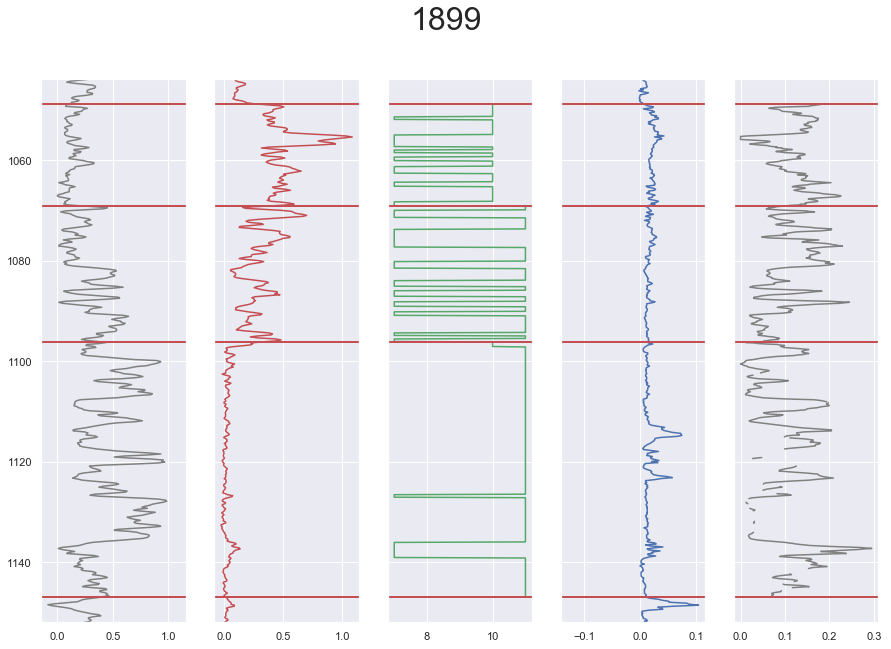

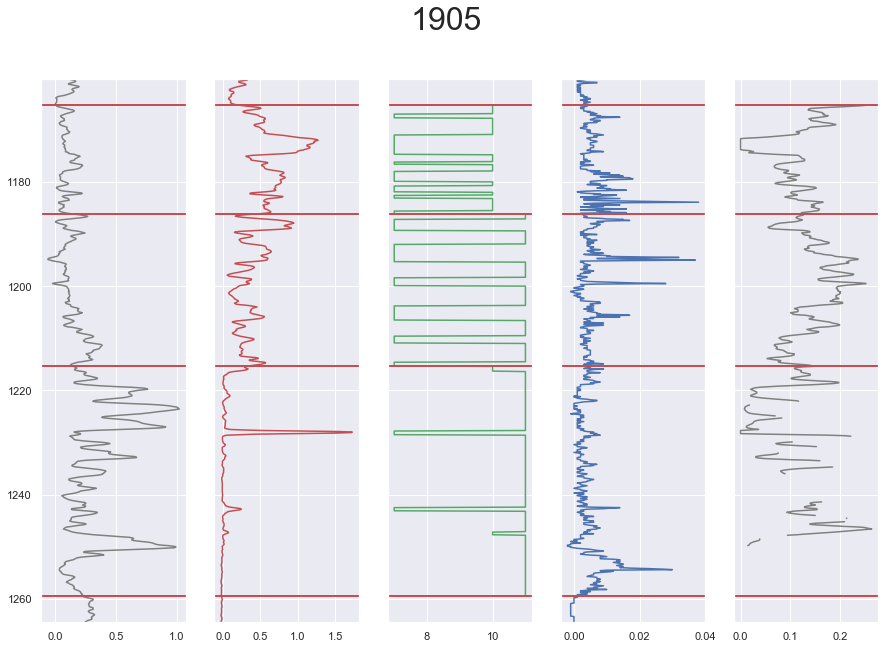

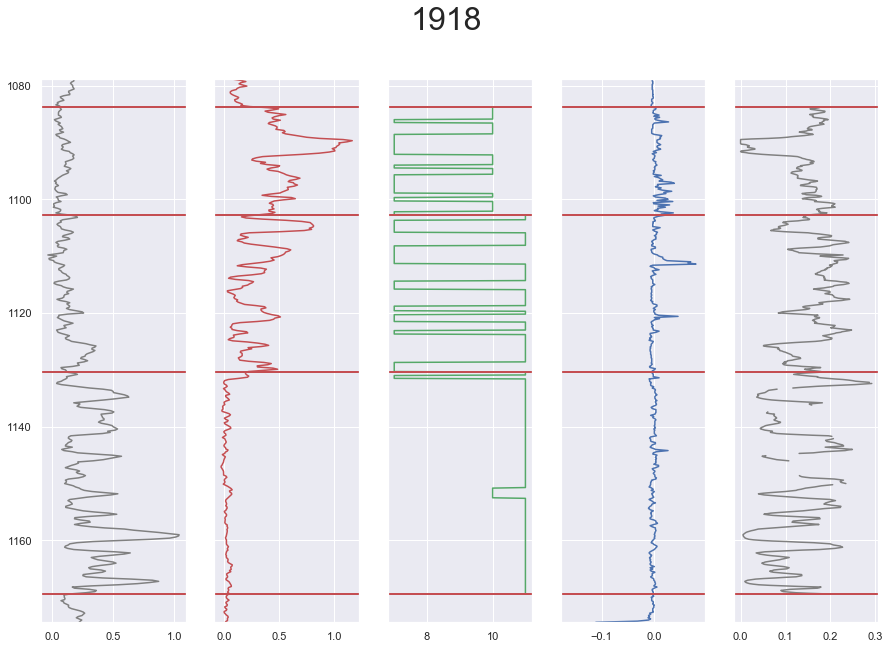

In [14]:
for well in wells_learn[:3]:
    fig, f = plt.subplots(nrows = 1, ncols = 5, sharey = True, figsize = (15,10))
    plt.suptitle(well.name,size =32)
    
    alias = ['ANG_auto','AG_auto','LITOLOGY','Cavern','Kp_auto']
    f[0].set_ylim(well.tops[0]-5, well.tops[3]+5)
    
    f[0].plot(well.curves[alias[0]], well.curves["DEPT"], "gray")
    f[1].plot(well.curves[alias[1]], well.curves["DEPT"], "r")
    f[2].plot(well.curves[alias[2]], well.curves["DEPT"], "g")
    f[3].plot(well.curves[alias[3]], well.curves["DEPT"], "b")
    f[4].plot(well.curves[alias[4]], well.curves["DEPT"], "gray")
    
    f[0].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[3].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[4].axhline(y = well.tops[0], color = 'r', linewidth = 2)

    f[0].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[3].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[4].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    
    f[0].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[3].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[4].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    
    f[0].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[3].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[4].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[0].invert_yaxis()
    
    plt.show()

In [15]:
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator

def get_feat(curves, cand, tops):
    lito = curves["LITO_LEARN"]
    dept = curves["DEPT"]
    crv1 = curves["AG_auto"]
    crv2 = curves["ANG_auto"]
    crv3 = curves["Cavern"]
    crv4 = curves['Kp_auto']
    
    tops_hor = tops
    ind4 = np.ones(len(dept), dtype = bool)
    ind4[np.isnan(crv4)] = False
    F_int4 = interp1d(dept[ind4], crv4[ind4], kind='nearest',fill_value = 'extrapolate')
    new_crv4 = F_int4(dept)
    crv4 = new_crv4
    
    ind2 = np.ones(len(dept), dtype = bool)
    ind2[np.isnan(crv2)] = False
    F_int2 = interp1d(dept[ind2], crv2[ind2], kind='nearest',fill_value = 'extrapolate')
    new_crv2 = F_int2(dept)
    crv2 = new_crv2
    
    ind3 = np.ones(len(dept), dtype = bool)
    ind3[np.isnan(crv3)] = False
    F_int3 = interp1d(dept[ind3], crv3[ind3], kind='nearest',fill_value = 'extrapolate')
    new_crv3 = F_int3(dept)
    crv3 = new_crv3
    
    ind1 = np.ones(len(dept), dtype = bool)
    ind1[np.isnan(crv1)] = False
    F_int1 = interp1d(dept[ind1], crv1[ind1], kind='nearest',fill_value = 'extrapolate')
    new_crv1 = F_int1(dept)
    crv1 = new_crv1
    
    #fig, f = plt.subplots(nrows = 1, ncols = 5, sharey = True, figsize = (15,10))
    #f[0].set_ylim(well.tops[0]-25, well.tops[3]+25)
    #f[0].plot(crv2, dept, "gray")
    #f[1].plot(crv1, dept, "r")
    #f[2].plot(lito, dept, "g")
    #f[3].plot(crv3, dept, "b")
    #f[4].plot(crv4, dept, "gray")
    #
    #f[0].axhline(y = tops[0], color = 'r', linewidth = 2)
    #f[1].axhline(y = tops[0], color = 'r', linewidth = 2)
    #f[2].axhline(y = tops[0], color = 'r', linewidth = 2)
    #f[3].axhline(y = tops[0], color = 'r', linewidth = 2)
    #f[4].axhline(y = tops[0], color = 'r', linewidth = 2)
#####
    #f[0].axhline(y = tops[1], color = 'r', linewidth = 2)
    #f[1].axhline(y = tops[1], color = 'r', linewidth = 2)
    #f[2].axhline(y = tops[1], color = 'r', linewidth = 2)
    #f[3].axhline(y = tops[1], color = 'r', linewidth = 2)
    #f[4].axhline(y = tops[1], color = 'r', linewidth = 2)
    #
    #f[0].axhline(y = tops[2], color = 'r', linewidth = 2)
    #f[1].axhline(y = tops[2], color = 'r', linewidth = 2)
    #f[2].axhline(y = tops[2], color = 'r', linewidth = 2)
    #f[3].axhline(y = tops[2], color = 'r', linewidth = 2)
    #f[4].axhline(y = tops[2], color = 'r', linewidth = 2)
    #
    #f[0].axhline(y = tops[3], color = 'r', linewidth = 2)
    #f[1].axhline(y = tops[3], color = 'r', linewidth = 2)
    #f[2].axhline(y = tops[3], color = 'r', linewidth = 2)
    #f[3].axhline(y = tops[3], color = 'r', linewidth = 2)
    #f[4].axhline(y = tops[3], color = 'r', linewidth = 2)
    #plt.show()
    
    f1 = np.array([])
    f2 = np.array([])
    f3 = np.array([])
    f4 = np.array([])
    f5 = np.array([])
    f6 = np.array([])
    f7 = np.array([])
    f8 = np.array([])
    f9 = np.array([])
    f10 = np.array([])
    f11 = np.array([])
    f12 = np.array([])
    f13 = np.array([])
    f14 = np.array([])
    f15 = np.array([])
    f16 = np.array([])
    f17 = np.array([])
    f18 = np.array([])
    f19 = np.array([])
    f20 = np.array([])
    f21 = np.array([])
    f22 = np.array([])
    f23 = np.array([])
    cur_label = np.array([])
    
    for i in range(len(cand)):
        C = cand[i]
        crv1_cut = crv1[C[0] : C[1]] 
        crv2_cut = crv2[C[0] : C[1]] 
        crv3_cut = crv3[C[0] : C[1]]
        crv4_cut = crv4[C[0] : C[1]]
        
        lito_cut = lito[C[0] : C[1]] 
        dept_cut = dept[C[0] : C[1]]
        
        val_f1 = np.nanmean(crv1_cut)
        val_f2 = np.nanmean(crv2_cut)
        val_f3 = np.nanmean(crv3_cut)
        val_f4 = np.nanmean(crv4_cut)
        
        if i == 0:
            val_f5 = np.nanmean(crv1[0 : C[0]])
            val_f6 = np.nanmean(crv2[0 : C[0]])
            val_f7 = np.nanmean(crv3[0 : C[0]])
            val_f8 = np.nanmean(crv4[0 : C[0]])
        else:
            val_f5 = np.nanmean(crv1[cand[i-1][0] : cand[i-1][1]])
            val_f6 = np.nanmean(crv2[cand[i-1][0] : cand[i-1][1]])
            val_f7 = np.nanmean(crv3[cand[i-1][0] : cand[i-1][1]])
            val_f8 = np.nanmean(crv4[cand[i-1][0] : cand[i-1][1]])
            
        if i == len(cand)-1:
            val_f9 = np.nanmean(crv1[C[1] : len(dept)])
            val_f10 = np.nanmean(crv2[C[1] : len(dept)])
            val_f11 = np.nanmean(crv3[C[1] : len(dept)])
            val_f12 = np.nanmean(crv4[C[1] : len(dept)])
            
        else:
            val_f9 = np.nanmean(crv1[cand[i+1][0] : cand[i+1][1]])
            val_f10 = np.nanmean(crv2[cand[i+1][0] : cand[i+1][1]])
            val_f11 = np.nanmean(crv3[cand[i+1][0] : cand[i+1][1]])
            val_f12 = np.nanmean(crv4[cand[i+1][0] : cand[i+1][1]])
        
        
        if st.mode(lito_cut)[0][0] == 0:
            continue
            
        f1 = np.append(f1 , val_f1)
        f2 = np.append(f2 , val_f2)
        f3 = np.append(f3 , val_f3)
        f4 = np.append(f4 , val_f4)
        f5 = np.append(f5 , val_f5)
        f6 = np.append(f6 , val_f6)
        f7 = np.append(f7 , val_f7)
        f8 = np.append(f8 , val_f8)
        f9 = np.append(f9 , val_f9)
        
        f10 = np.append(f10 , val_f10)
        f11 = np.append(f11 , val_f11)
        f12 = np.append(f12 , val_f12)
        
        cur_label = np.append(cur_label, st.mode(lito_cut)[0][0])
        
    features = np.vstack((
                          f1 ,
                          f2 ,
                          f3 ,
                          f4 ,
                          f5 ,
                          f6 ,
                          f7 ,
                          f8 ,
                          f9 ,
        #
                          f10,
                          f11,
                          f12
                         ))
    return features, cur_label

In [16]:
features = None
labels = None
for well in wells_learn[ :]:
    this_features, cur_Labels = get_feat(well.curves, well.CAND,well.tops)
    if features is not None:
        features = np.hstack((features, this_features))
        labels = np.hstack((labels, cur_Labels))
    else:
        features = this_features
        labels = cur_Labels
features = features.T

In [17]:
features_test = None
labels_test = None
for well in wells_test[ : ]:
    this_features, cur_Labels = get_feat(well.curves, well.CAND,well.tops)
    if features_test is not None:
        features_test = np.hstack((features_test, this_features))
        labels_test = np.hstack((labels_test, cur_Labels))
    else:
        features_test = this_features
        labels_test = cur_Labels
features_test = features_test.T

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
labels_test = le.fit_transform(labels_test)

In [19]:
print(len(features), len(labels))

6123 6123


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score , recall_score, precision_score , make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, learning_curve

In [21]:
baseline_clf = GradientBoostingClassifier(learning_rate = 0.01,
                                 subsample = 0.5,
                                max_depth = 40,
                                max_features = 'auto')
baseline_clf.fit(features,labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=40,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [22]:
baseline_prediction = baseline_clf.predict(features_test)
f1_base = f1_score(labels_test, baseline_prediction, average='macro')
print('F1 метрика macro baseline модели равна %.4f'%f1_base)
f1_base1 = f1_score(labels_test, baseline_prediction, average='weighted')
print('F1 метрика weighted baseline модели равна %.4f'%f1_base1)

rec_base = recall_score(labels_test, baseline_prediction, average='macro')
print('Recall метрика macro baseline модели равна %.4f'%rec_base)

rec_base1 = recall_score(labels_test, baseline_prediction, average='weighted')
print('Recall метрика weighted baseline модели равна %.4f'%rec_base1)

prec_base = precision_score(labels_test, baseline_prediction, average='macro')
print('Precision метрика macro baseline модели равна %.4f'%prec_base)

prec_base1 = precision_score(labels_test, baseline_prediction, average='weighted')
print('Precision метрика weighted baseline модели равна %.4f'%prec_base1)

F1 метрика macro baseline модели равна 0.8251
F1 метрика weighted baseline модели равна 0.9570
Recall метрика macro baseline модели равна 0.7658
Recall метрика weighted baseline модели равна 0.9590
Precision метрика macro baseline модели равна 0.9656
Precision метрика weighted baseline модели равна 0.9591


In [23]:
def get_feat_final(curves, cand, tops):
    lito = curves["LITO_LEARN"]
    dept = curves["DEPT"]
    alias = ["ANG_auto","AG_auto","Cavern","Kp_auto"]
    
    ### Заполнение кривых
    crv = []
    crv_grad = []
    crv_pow2 = []
    for key in alias:
        crv.append(curves[key])
        crv_grad.append(np.gradient(curves[key]))
        crv_pow2.append(curves[key]*curves[key])
    tops_hor = tops
    
    #Экстраполяция для исходных кривых
    for i in range(4):
        ind = None
        ind = np.ones(len(dept), dtype = bool)
        ind[np.isnan(crv[i])] = False
        F_int = interp1d(dept[ind], crv[i][ind], kind='nearest',fill_value = 'extrapolate')
        new_crv = F_int(dept)
        crv[i] = new_crv
    #Экстраполяция для градиента кривых
    for i in range(4):
        ind = None
        ind = np.ones(len(dept), dtype = bool)
        ind[np.isnan(crv_grad[i])] = False
        F_int = interp1d(dept[ind], crv_grad[i][ind], kind='nearest',fill_value = 'extrapolate')
        new_crv = F_int(dept)
        crv_grad[i] = new_crv
    #Экстраполяция для квадрата кривых
    for i in range(4):
        ind = None
        ind = np.ones(len(dept), dtype = bool)
        ind[np.isnan(crv_pow2[i])] = False
        F_int = interp1d(dept[ind], crv_pow2[i][ind], kind='nearest',fill_value = 'extrapolate')
        new_crv = F_int(dept)
        crv_pow2[i] = new_crv
        
    f1 = np.array([])
    f2 = np.array([])
    f3 = np.array([])
    f4 = np.array([])
    f5 = np.array([])
    f6 = np.array([])
    f7 = np.array([])
    f8 = np.array([])
    f9 = np.array([])
    f10 = np.array([])
    f11 = np.array([])
    f12 = np.array([])
    
    max_f1  = np.array([])
    max_f2  = np.array([])
    max_f3  = np.array([])
    max_f4  = np.array([])
    max_f5  = np.array([])
    max_f6  = np.array([])
    max_f7  = np.array([])
    max_f8  = np.array([])
    max_f9  = np.array([])
    max_f10 = np.array([])
    max_f11 = np.array([])
    max_f12 = np.array([])
    
    min_f1  = np.array([])
    min_f2  = np.array([])
    min_f3  = np.array([])
    min_f4  = np.array([])
    min_f5  = np.array([])
    min_f6  = np.array([])
    min_f7  = np.array([])
    min_f8  = np.array([])
    min_f9  = np.array([])
    min_f10 = np.array([])
    min_f11 = np.array([])
    min_f12 = np.array([])
    
    grad_f1  = np.array([])
    grad_f2  = np.array([])
    grad_f3  = np.array([])
    grad_f4  = np.array([])
    grad_f5  = np.array([])
    grad_f6  = np.array([])
    grad_f7  = np.array([])
    grad_f8  = np.array([])
    grad_f9  = np.array([])
    grad_f10 = np.array([])
    grad_f11 = np.array([])
    grad_f12 = np.array([])
    
    pow2_f1  = np.array([])
    pow2_f2  = np.array([])
    pow2_f3  = np.array([])
    pow2_f4  = np.array([])
    pow2_f5  = np.array([])
    pow2_f6  = np.array([])
    pow2_f7  = np.array([])
    pow2_f8  = np.array([])
    pow2_f9  = np.array([])
    pow2_f10 = np.array([])
    pow2_f11 = np.array([])
    pow2_f12 = np.array([])
    
    cur_label = np.array([])
    
    for i in range(len(cand)):
        C = cand[i]
        crv_cut = []
        crv_grad_cut = []
        crv_pow2_cut = []
        for cur_crv in crv:
            crv_cut.append(cur_crv[C[0] : C[1]])
        for cur_crv in crv_grad:
            crv_grad_cut.append(cur_crv[C[0] : C[1]])
        for cur_crv in crv_pow2:
            crv_pow2_cut.append(cur_crv[C[0] : C[1]])
        
        val_f1 = np.nanmean(crv_cut[0])
        val_f2 = np.nanmean(crv_cut[1])
        val_f3 = np.nanmean(crv_cut[2])
        val_f4 = np.nanmean(crv_cut[3])
        
        val_max_f1 = np.nanmax(crv_cut[0])
        val_max_f2 = np.nanmax(crv_cut[1])
        val_max_f3 = np.nanmax(crv_cut[2])
        val_max_f4 = np.nanmax(crv_cut[3])
        
        val_min_f1 = np.nanmin(crv_cut[0])
        val_min_f2 = np.nanmin(crv_cut[1])
        val_min_f3 = np.nanmin(crv_cut[2])
        val_min_f4 = np.nanmin(crv_cut[3])
        
        val_grad_f1 = np.nanmean(crv_grad_cut[0])
        val_grad_f2 = np.nanmean(crv_grad_cut[1])
        val_grad_f3 = np.nanmean(crv_grad_cut[2])
        val_grad_f4 = np.nanmean(crv_grad_cut[3])
        
        val_pow2_f1 = np.nanmean(crv_pow2_cut[0])
        val_pow2_f2 = np.nanmean(crv_pow2_cut[1])
        val_pow2_f3 = np.nanmean(crv_pow2_cut[2])
        val_pow2_f4 = np.nanmean(crv_pow2_cut[3])
      
        lito_cut = lito[C[0] : C[1]] 
        dept_cut = dept[C[0] : C[1]]
        
        if i == 0:
            val_f5 = np.nanmean(crv[0][0 : C[0]])
            val_f6 = np.nanmean(crv[1][0 : C[0]])
            val_f7 = np.nanmean(crv[2][0 : C[0]])
            val_f8 = np.nanmean(crv[3][0 : C[0]])
            
            val_max_f5 = np.nanmax(crv[0][0 : C[0]])
            val_max_f6 = np.nanmax(crv[1][0 : C[0]])
            val_max_f7 = np.nanmax(crv[2][0 : C[0]])
            val_max_f8 = np.nanmax(crv[3][0 : C[0]])
            
            val_min_f5 = np.nanmin(crv[0][0 : C[0]])
            val_min_f6 = np.nanmin(crv[1][0 : C[0]])
            val_min_f7 = np.nanmin(crv[2][0 : C[0]])
            val_min_f8 = np.nanmin(crv[3][0 : C[0]])
            
            val_grad_f5 = np.nanmean(crv_grad[0][0 : C[0]])
            val_grad_f6 = np.nanmean(crv_grad[1][0 : C[0]])
            val_grad_f7 = np.nanmean(crv_grad[2][0 : C[0]])
            val_grad_f8 = np.nanmean(crv_grad[3][0 : C[0]])
            
            val_pow2_f5 = np.nanmean(crv_pow2[0][0 : C[0]])
            val_pow2_f6 = np.nanmean(crv_pow2[1][0 : C[0]])
            val_pow2_f7 = np.nanmean(crv_pow2[2][0 : C[0]])
            val_pow2_f8 = np.nanmean(crv_pow2[3][0 : C[0]])
        else:
            val_f5 = np.nanmean(crv[0][cand[i-1][0] : cand[i-1][1]])
            val_f6 = np.nanmean(crv[1][cand[i-1][0] : cand[i-1][1]])
            val_f7 = np.nanmean(crv[2][cand[i-1][0] : cand[i-1][1]])
            val_f8 = np.nanmean(crv[3][cand[i-1][0] : cand[i-1][1]])
            
            val_max_f5 = np.nanmax(crv[0][cand[i-1][0] : cand[i-1][1]])
            val_max_f6 = np.nanmax(crv[1][cand[i-1][0] : cand[i-1][1]])
            val_max_f7 = np.nanmax(crv[2][cand[i-1][0] : cand[i-1][1]])
            val_max_f8 = np.nanmax(crv[3][cand[i-1][0] : cand[i-1][1]])
            
            val_min_f5 = np.nanmin(crv[0][cand[i-1][0] : cand[i-1][1]])
            val_min_f6 = np.nanmin(crv[1][cand[i-1][0] : cand[i-1][1]])
            val_min_f7 = np.nanmin(crv[2][cand[i-1][0] : cand[i-1][1]])
            val_min_f8 = np.nanmin(crv[3][cand[i-1][0] : cand[i-1][1]])
            
            val_grad_f5 = np.nanmean(crv_grad[0][cand[i-1][0] : cand[i-1][1]])
            val_grad_f6 = np.nanmean(crv_grad[1][cand[i-1][0] : cand[i-1][1]])
            val_grad_f7 = np.nanmean(crv_grad[2][cand[i-1][0] : cand[i-1][1]])
            val_grad_f8 = np.nanmean(crv_grad[3][cand[i-1][0] : cand[i-1][1]])
            
            val_pow2_f5 = np.nanmean(crv_pow2[0][cand[i-1][0] : cand[i-1][1]])
            val_pow2_f6 = np.nanmean(crv_pow2[1][cand[i-1][0] : cand[i-1][1]])
            val_pow2_f7 = np.nanmean(crv_pow2[2][cand[i-1][0] : cand[i-1][1]])
            val_pow2_f8 = np.nanmean(crv_pow2[3][cand[i-1][0] : cand[i-1][1]])
            
            
        if i == len(cand)-1:
            val_f9  = np.nanmean(crv[0][C[1] : len(dept)])
            val_f10 = np.nanmean(crv[1][C[1] : len(dept)])
            val_f11 = np.nanmean(crv[2][C[1] : len(dept)])
            val_f12 = np.nanmean(crv[3][C[1] : len(dept)])
            
            val_max_f9  = np.nanmax(crv[0][C[1] : len(dept)])
            val_max_f10 = np.nanmax(crv[1][C[1] : len(dept)])
            val_max_f11 = np.nanmax(crv[2][C[1] : len(dept)])
            val_max_f12 = np.nanmax(crv[3][C[1] : len(dept)])
            
            val_min_f9  = np.nanmin(crv[0][C[1] : len(dept)])
            val_min_f10 = np.nanmin(crv[1][C[1] : len(dept)])
            val_min_f11 = np.nanmin(crv[2][C[1] : len(dept)])
            val_min_f12 = np.nanmin(crv[3][C[1] : len(dept)])
            
            val_grad_f9  = np.nanmean(crv_grad[0][C[1] : len(dept)])
            val_grad_f10 = np.nanmean(crv_grad[1][C[1] : len(dept)])
            val_grad_f11 = np.nanmean(crv_grad[2][C[1] : len(dept)])
            val_grad_f12 = np.nanmean(crv_grad[3][C[1] : len(dept)])
            
            val_pow2_f9  = np.nanmean(crv_pow2[0][C[1] : len(dept)])
            val_pow2_f10 = np.nanmean(crv_pow2[1][C[1] : len(dept)])
            val_pow2_f11 = np.nanmean(crv_pow2[2][C[1] : len(dept)])
            val_pow2_f12 = np.nanmean(crv_pow2[3][C[1] : len(dept)])
            
        else:
            val_f9  = np.nanmean(crv[0][cand[i+1][0] : cand[i+1][1]])
            val_f10 = np.nanmean(crv[1][cand[i+1][0] : cand[i+1][1]])
            val_f11 = np.nanmean(crv[2][cand[i+1][0] : cand[i+1][1]])
            val_f12 = np.nanmean(crv[3][cand[i+1][0] : cand[i+1][1]])
            
            val_max_f9  = np.nanmax(crv[0][cand[i+1][0] : cand[i+1][1]])
            val_max_f10 = np.nanmax(crv[1][cand[i+1][0] : cand[i+1][1]])
            val_max_f11 = np.nanmax(crv[2][cand[i+1][0] : cand[i+1][1]])
            val_max_f12 = np.nanmax(crv[3][cand[i+1][0] : cand[i+1][1]])
            
            val_min_f9  = np.nanmin(crv[0][cand[i+1][0] : cand[i+1][1]])
            val_min_f10 = np.nanmin(crv[1][cand[i+1][0] : cand[i+1][1]])
            val_min_f11 = np.nanmin(crv[2][cand[i+1][0] : cand[i+1][1]])
            val_min_f12 = np.nanmin(crv[3][cand[i+1][0] : cand[i+1][1]])
            
            val_grad_f9  = np.nanmean(crv_grad[0][cand[i+1][0] : cand[i+1][1]])
            val_grad_f10 = np.nanmean(crv_grad[1][cand[i+1][0] : cand[i+1][1]])
            val_grad_f11 = np.nanmean(crv_grad[2][cand[i+1][0] : cand[i+1][1]])
            val_grad_f12 = np.nanmean(crv_grad[3][cand[i+1][0] : cand[i+1][1]])
            
            val_pow2_f9  = np.nanmean(crv_pow2[0][cand[i+1][0] : cand[i+1][1]])
            val_pow2_f10 = np.nanmean(crv_pow2[1][cand[i+1][0] : cand[i+1][1]])
            val_pow2_f11 = np.nanmean(crv_pow2[2][cand[i+1][0] : cand[i+1][1]])
            val_pow2_f12 = np.nanmean(crv_pow2[3][cand[i+1][0] : cand[i+1][1]])
            
            
        
        
        if st.mode(lito_cut)[0][0] == 0:
            continue
            
        f1 = np.append(f1 , val_f1)
        f2 = np.append(f2 , val_f2)
        f3 = np.append(f3 , val_f3)
        f4 = np.append(f4 , val_f4)
        f5 = np.append(f5 , val_f5)
        f6 = np.append(f6 , val_f6)
        f7 = np.append(f7 , val_f7)
        f8 = np.append(f8 , val_f8)
        f9 = np.append(f9 , val_f9)
        f10 = np.append(f10 , val_f10)
        f11 = np.append(f11 , val_f11)
        f12 = np.append(f12 , val_f12)
        
        max_f1   = np.append(max_f1   , val_max_f1)
        max_f2   = np.append(max_f2   , val_max_f2)
        max_f3   = np.append(max_f3   , val_max_f3)
        max_f4   = np.append(max_f4   , val_max_f4)
        max_f5   = np.append(max_f5   , val_max_f5)
        max_f6   = np.append(max_f6   , val_max_f6)
        max_f7   = np.append(max_f7   , val_max_f7)
        max_f8   = np.append(max_f8   , val_max_f8)
        max_f9   = np.append(max_f9   , val_max_f9)
        max_f10  = np.append(max_f10  , val_max_f10)
        max_f11  = np.append(max_f11  , val_max_f11)
        max_f12  = np.append(max_f12  , val_max_f12)
        
        min_f1   = np.append(min_f1   , val_min_f1)
        min_f2   = np.append(min_f2   , val_min_f2)
        min_f3   = np.append(min_f3   , val_min_f3)
        min_f4   = np.append(min_f4   , val_min_f4)
        min_f5   = np.append(min_f5   , val_min_f5)
        min_f6   = np.append(min_f6   , val_min_f6)
        min_f7   = np.append(min_f7   , val_min_f7)
        min_f8   = np.append(min_f8   , val_min_f8)
        min_f9   = np.append(min_f9   , val_min_f9)
        min_f10  = np.append(min_f10  , val_min_f10)
        min_f11  = np.append(min_f11  , val_min_f11)
        min_f12  = np.append(min_f12  , val_min_f12)
        
        grad_f1  = np.append(grad_f1  , val_grad_f1)
        grad_f2  = np.append(grad_f2  , val_grad_f2)
        grad_f3  = np.append(grad_f3  , val_grad_f3)
        grad_f4  = np.append(grad_f4  , val_grad_f4)
        grad_f5  = np.append(grad_f5  , val_grad_f5)
        grad_f6  = np.append(grad_f6  , val_grad_f6)
        grad_f7  = np.append(grad_f7  , val_grad_f7)
        grad_f8  = np.append(grad_f8  , val_grad_f8)
        grad_f9  = np.append(grad_f9  , val_grad_f9)
        grad_f10 = np.append(grad_f10 , val_grad_f10)
        grad_f11 = np.append(grad_f11 , val_grad_f11)
        grad_f12 = np.append(grad_f12 , val_grad_f12)
        
        pow2_f1  = np.append(pow2_f1  , val_pow2_f1)
        pow2_f2  = np.append(pow2_f2  , val_pow2_f2)
        pow2_f3  = np.append(pow2_f3  , val_pow2_f3)
        pow2_f4  = np.append(pow2_f4  , val_pow2_f4)
        pow2_f5  = np.append(pow2_f5  , val_pow2_f5)
        pow2_f6  = np.append(pow2_f6  , val_pow2_f6)
        pow2_f7  = np.append(pow2_f7  , val_pow2_f7)
        pow2_f8  = np.append(pow2_f8  , val_pow2_f8)
        pow2_f9  = np.append(pow2_f9  , val_pow2_f9)
        pow2_f10 = np.append(pow2_f10 , val_pow2_f10)
        pow2_f11 = np.append(pow2_f11 , val_pow2_f11)
        pow2_f12 = np.append(pow2_f12 , val_pow2_f12)
        
        cur_label = np.append(cur_label, st.mode(lito_cut)[0][0])
        
    features = np.vstack((
                          f1 ,
                          f2 ,
                          f3 ,
                          f4 ,
                          f5 ,
                          f6 ,
                          f7 ,
                          f8 ,
                          f9 ,
                          f10,
                          f11,
                          f12,
                          max_f1 ,
                          max_f2 ,
                          max_f3 ,
                          max_f4 ,
                          max_f5 ,
                          max_f6 ,
                          max_f7 ,
                          max_f8 ,
                          max_f9 ,
                          max_f10,
                          max_f11,
                          max_f12,
                          min_f1 ,
                          min_f2 ,
                          min_f3 ,
                          min_f4 ,
                          min_f5 ,
                          min_f6 ,
                          min_f7 ,
                          min_f8 ,
                          min_f9 ,
                          min_f10,
                          min_f11,
                          min_f12,
                          grad_f1 , 
                          grad_f2 , 
                          grad_f3 , 
                          grad_f4 , 
                          grad_f5 , 
                          grad_f6 , 
                          grad_f7 , 
                          grad_f8 , 
                          grad_f9 , 
                          grad_f10, 
                          grad_f11, 
                          grad_f12,
                          pow2_f1 ,
                          pow2_f2 ,
                          pow2_f3 ,
                          pow2_f4 ,
                          pow2_f5 ,
                          pow2_f6 ,
                          pow2_f7 ,
                          pow2_f8 ,
                          pow2_f9 ,
                          pow2_f10,
                          pow2_f11,
                          pow2_f12
                         ))
    return features, cur_label

In [24]:
features_final = None
labels_final = None
for well in wells_learn[:]:
    this_features, cur_Labels = get_feat_final(well.curves, well.CAND,well.tops)
    if features_final is not None:
        features_final = np.hstack((features_final, this_features))
        labels_final = np.hstack((labels_final, cur_Labels))
    else:
        features_final = this_features
        labels_final = cur_Labels
features_final = features_final.T

In [25]:
print(len(features_final) ,len(labels_final))

6123 6123


In [26]:
labels_final = le.fit_transform(labels_final)

In [27]:
features_final_test = None
labels_final_test = None
for well in wells_test[:]:
    this_features, cur_Labels = get_feat_final(well.curves, well.CAND,well.tops)
    if features_final_test is not None:
        features_final_test = np.hstack((features_final_test, this_features))
        labels_final_test = np.hstack((labels_final_test, cur_Labels))
    else:
        features_final_test = this_features
        labels_final_test = cur_Labels
features_final_test = features_final_test.T

In [28]:
labels_final_test = le.fit_transform(labels_final_test)

In [29]:
clf = GradientBoostingClassifier(learning_rate = 0.01,
                                subsample = 0.5,
                                max_depth = 50,
                                warm_start = True,
                                 min_samples_split  = 4,
                                n_estimators = 400,
                                verbose = 1,
                                max_features = 'auto')
clf.fit(features_final,labels_final)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        2474.7360          33.5488            2.33m
         2        2453.1097          32.4785            4.17m
         3        2408.1801          31.2129            4.90m
         4        2377.8562          30.4508            5.56m
         5        2349.4093          30.5117            5.95m
         6        2294.9387          29.7961            6.22m
         7        2264.0550          29.8071            6.31m
         8        2230.4992          28.2855            6.51m
         9        2207.1706          27.6869            6.68m
        10        2172.2263          27.7151            6.72m
        20        1884.5463          21.6783            6.64m
        30        1656.5310          19.0708            6.67m
        40        1438.1391          15.7216            6.78m
        50        1274.2035          13.4979            6.71m
        60        1118.8354          11.4522            6.76m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=50,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=True)

In [30]:
baseline_prediction = clf.predict(features_final_test)
f1_base = f1_score(labels_final_test, baseline_prediction, average='macro')
print('F1 метрика macro baseline модели равна %.4f'%f1_base)
f1_base1 = f1_score(labels_final_test, baseline_prediction, average='weighted')
print('F1 метрика weighted baseline модели равна %.4f'%f1_base1)

rec_base = recall_score(labels_final_test, baseline_prediction, average='macro')
print('Recall метрика macro baseline модели равна %.4f'%rec_base)

rec_base1 = recall_score(labels_final_test, baseline_prediction, average='weighted')
print('Recall метрика weighted baseline модели равна %.4f'%rec_base1)

prec_base = precision_score(labels_final_test, baseline_prediction, average='macro')
print('Precision метрика macro baseline модели равна %.4f'%prec_base)

prec_base1 = precision_score(labels_final_test, baseline_prediction, average='weighted')
print('Precision метрика weighted baseline модели равна %.4f'%prec_base1)

F1 метрика macro baseline модели равна 0.8644
F1 метрика weighted baseline модели равна 0.9650
Recall метрика macro baseline модели равна 0.8108
Recall метрика weighted baseline модели равна 0.9661
Precision метрика macro baseline модели равна 0.9692
Precision метрика weighted baseline модели равна 0.9663


In [ ]:
import pickle
obj = {"clf": clf}
output = open('pickle/vrk_bash_lito_v2.pickle', 'wb')
pickle.dump(obj, output)
output.close()


In [ ]:
import pickle
with open("pickle/vrk_bash_lito_v2.pickle", 'rb') as f:
    tmp =  pickle.load(f)
    clf = tmp["clf"]
f.close()

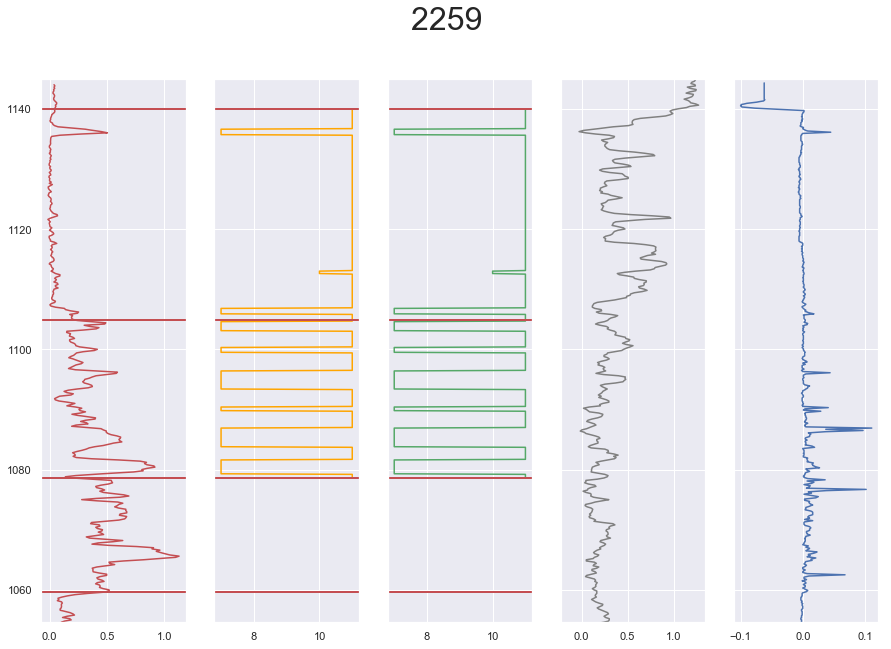

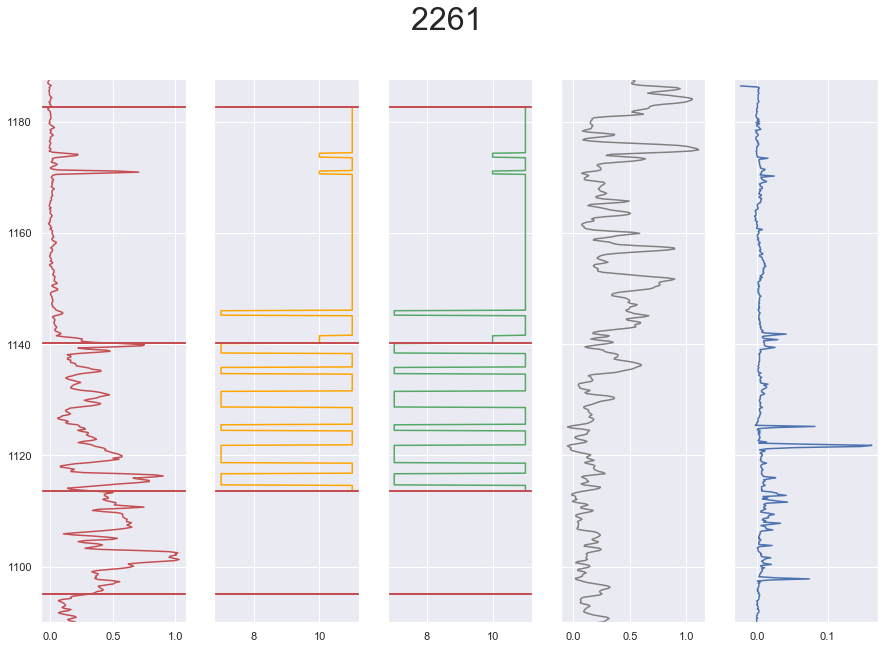

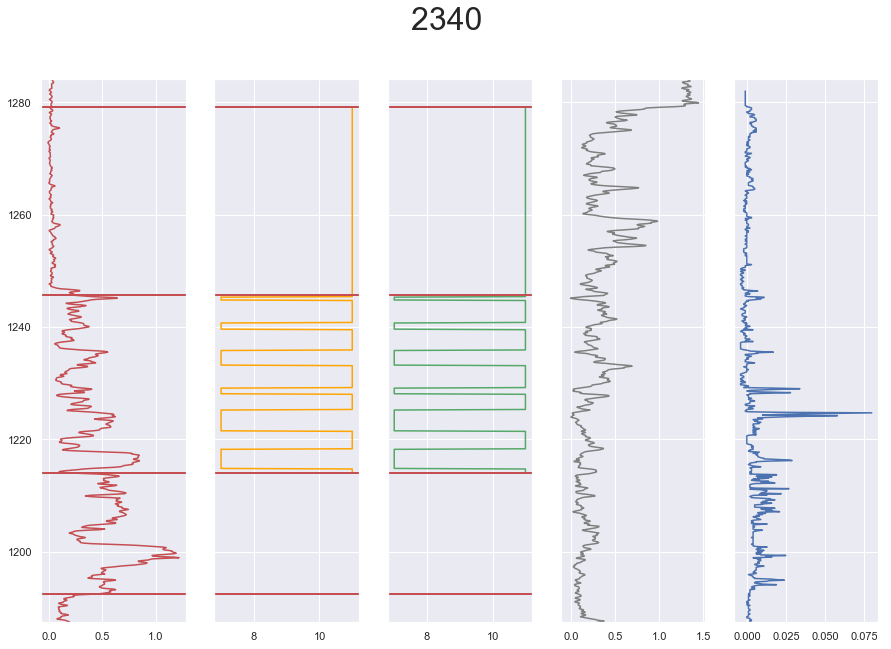

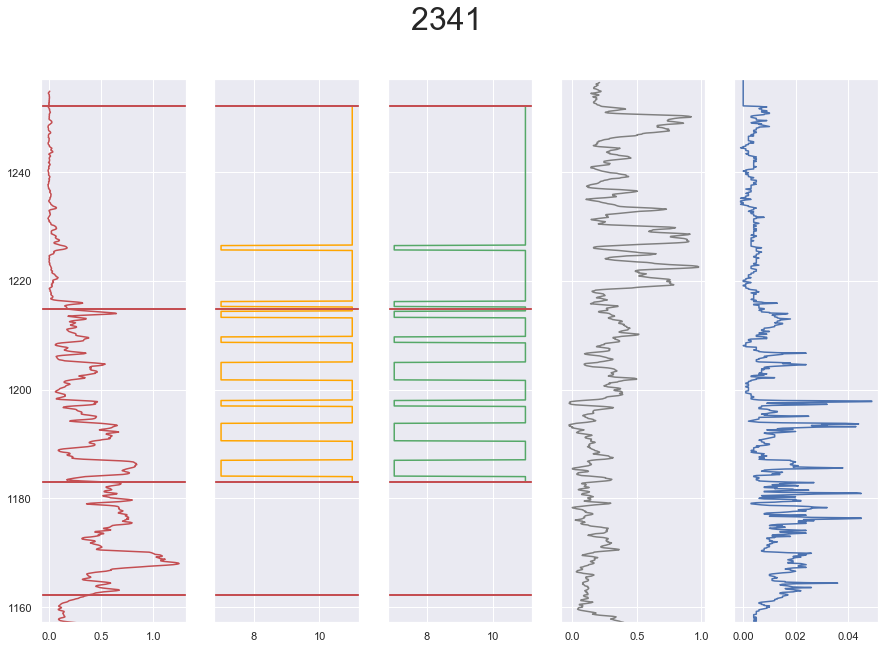

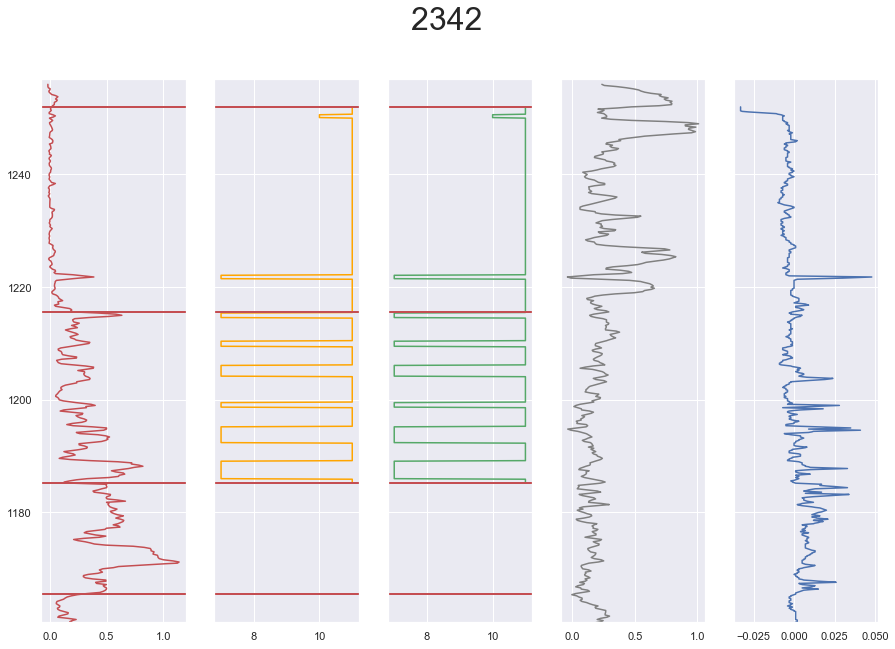

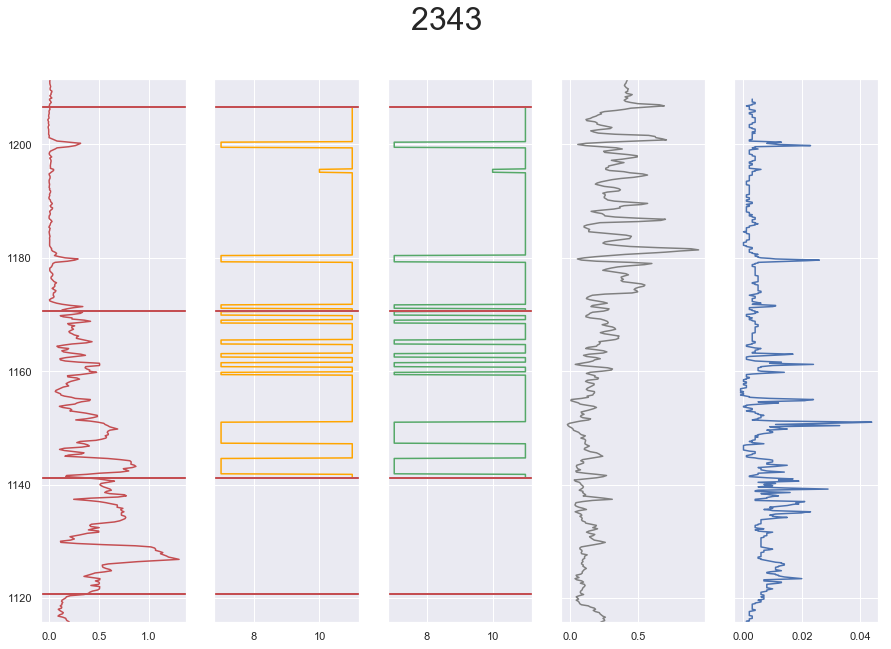

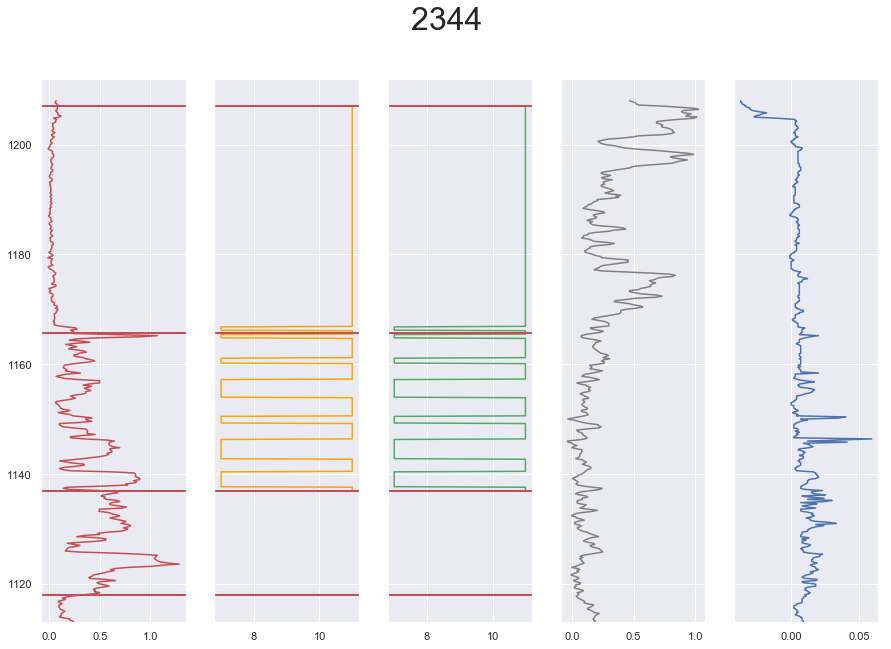

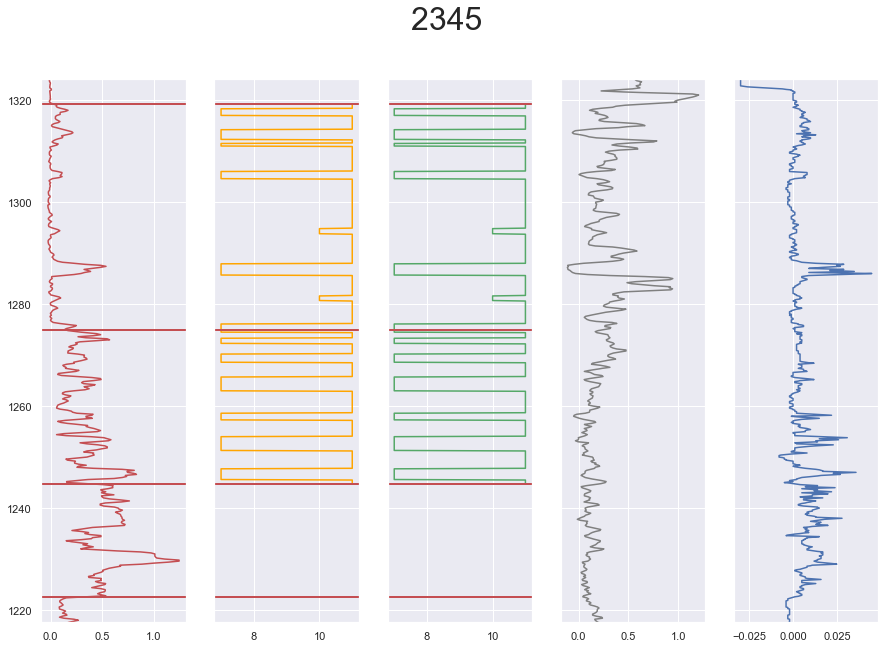

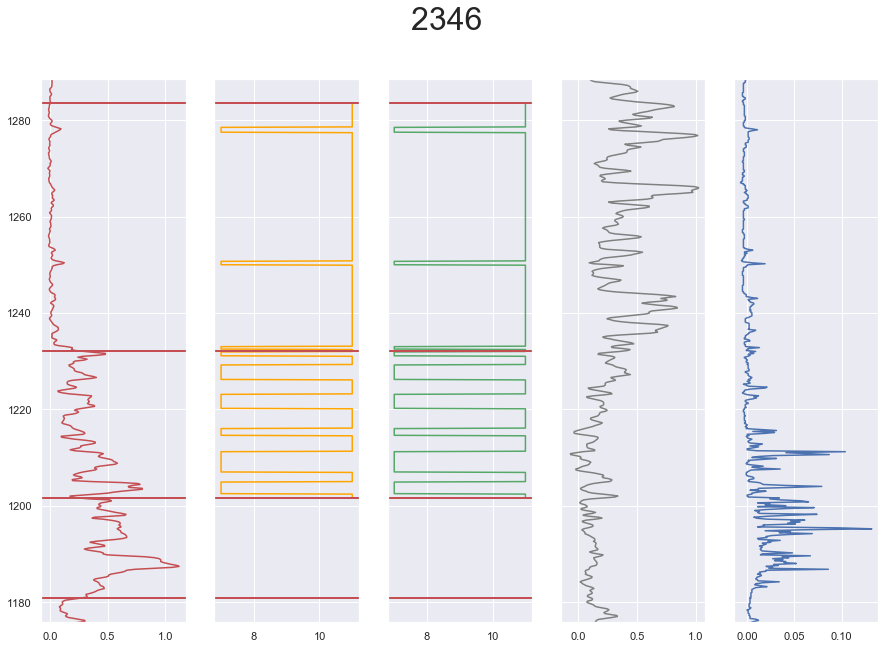

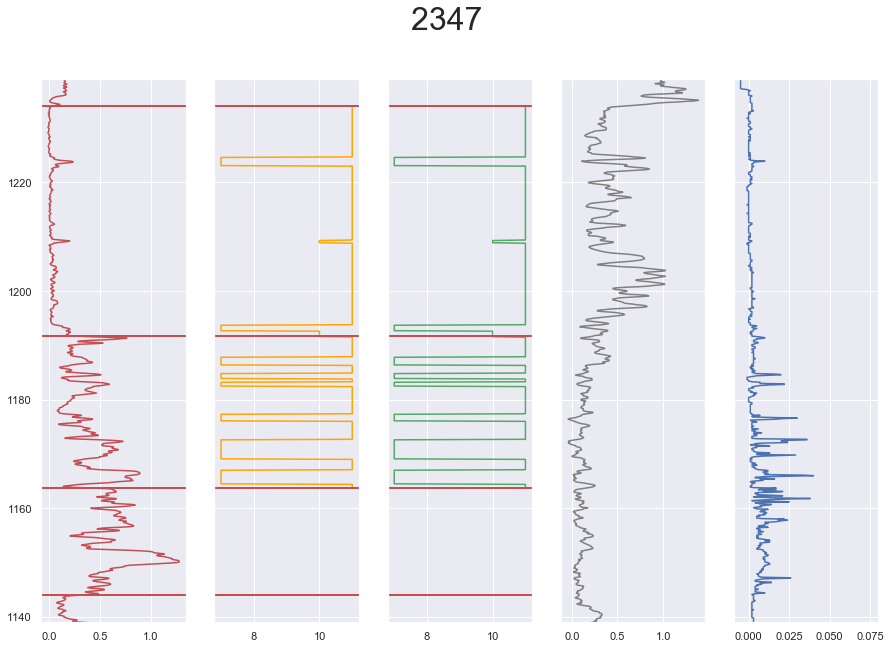

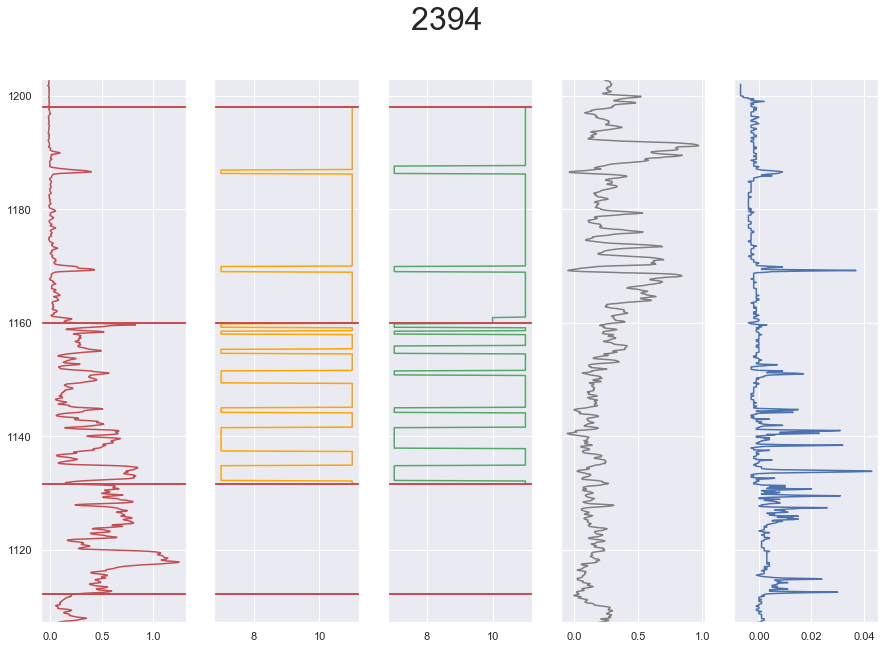

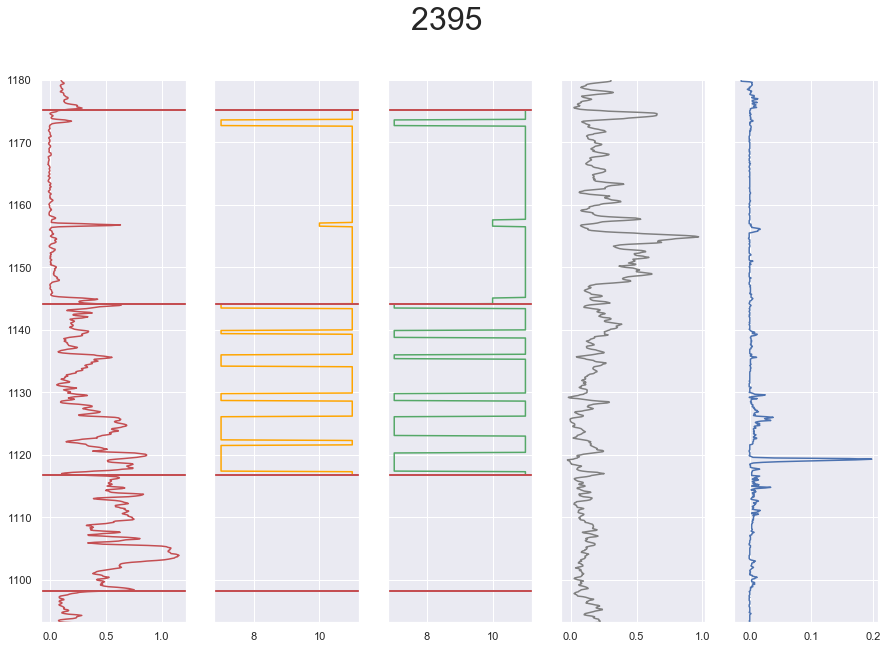

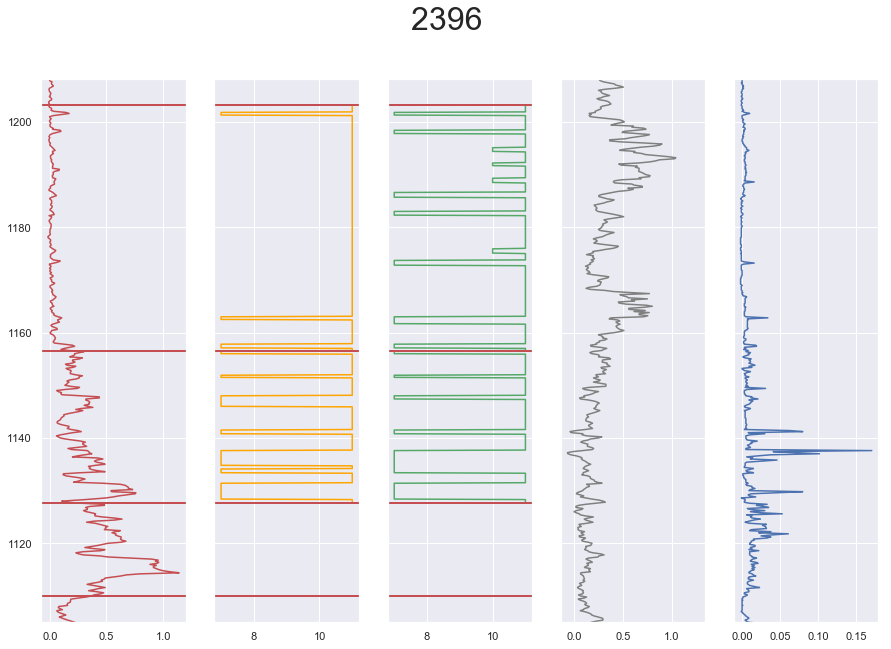

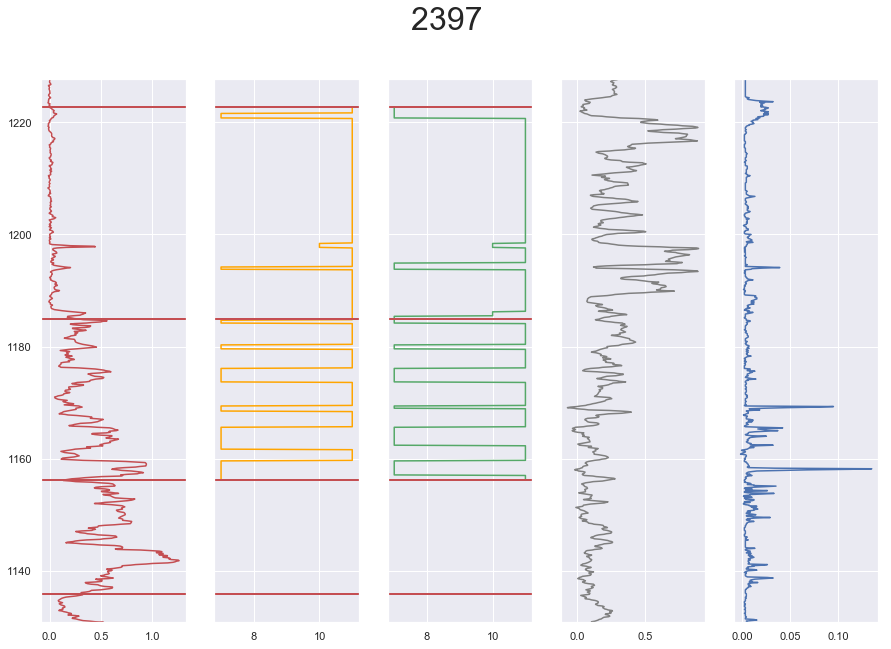

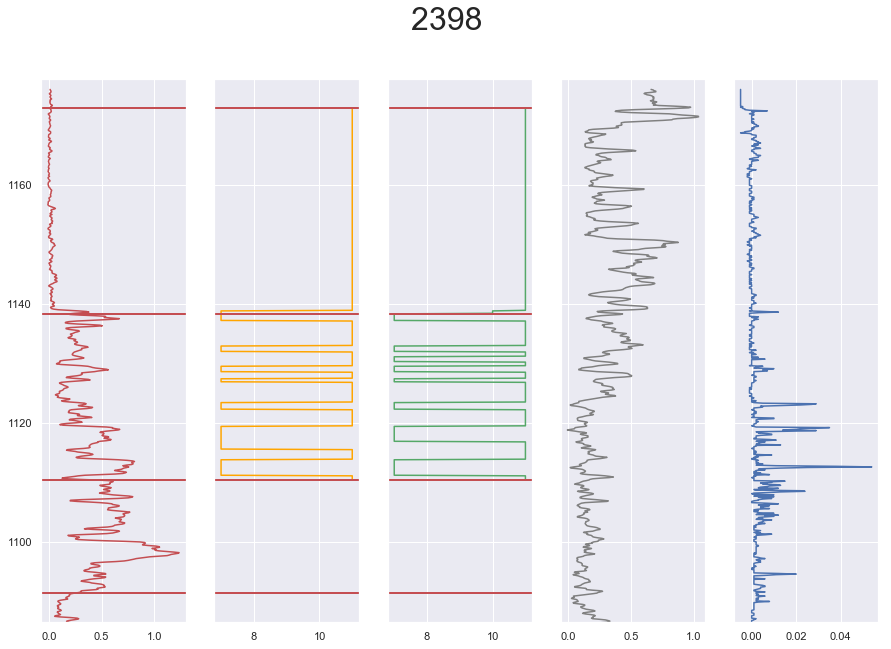

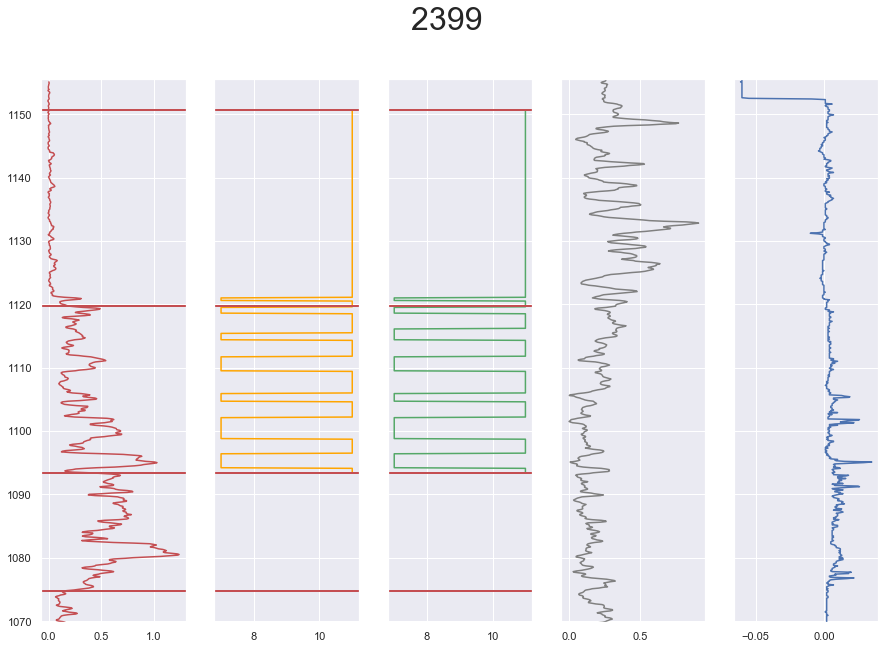

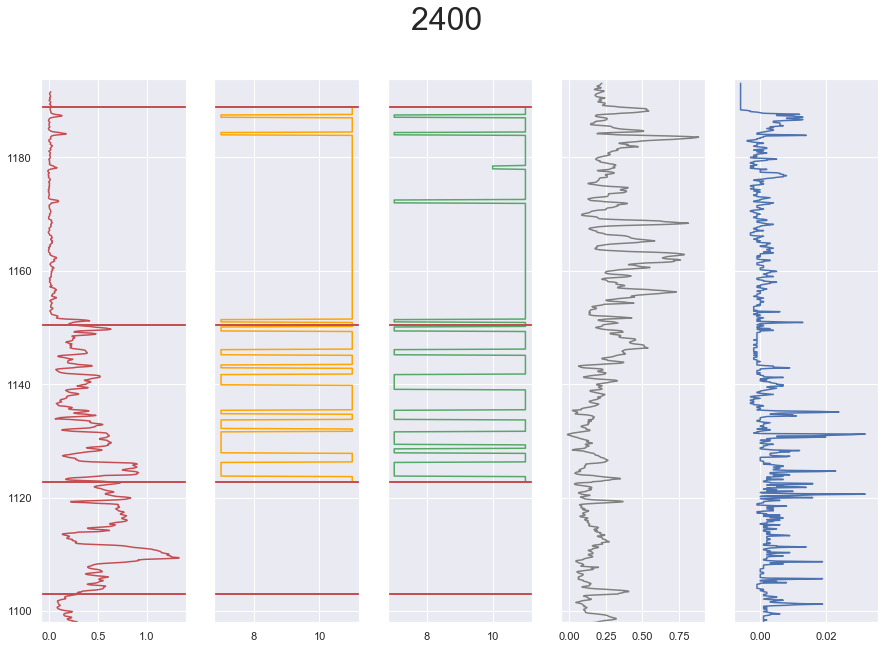

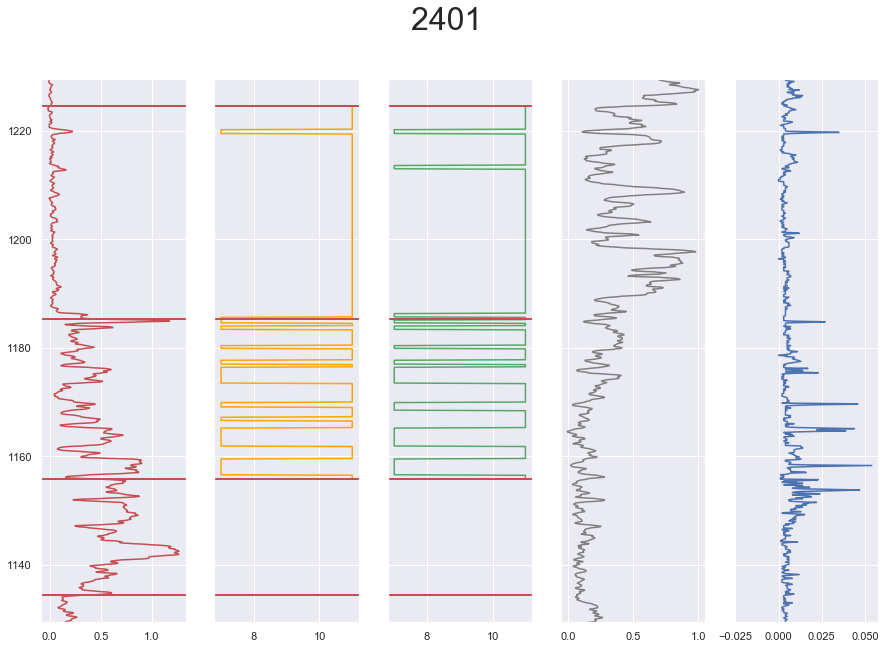

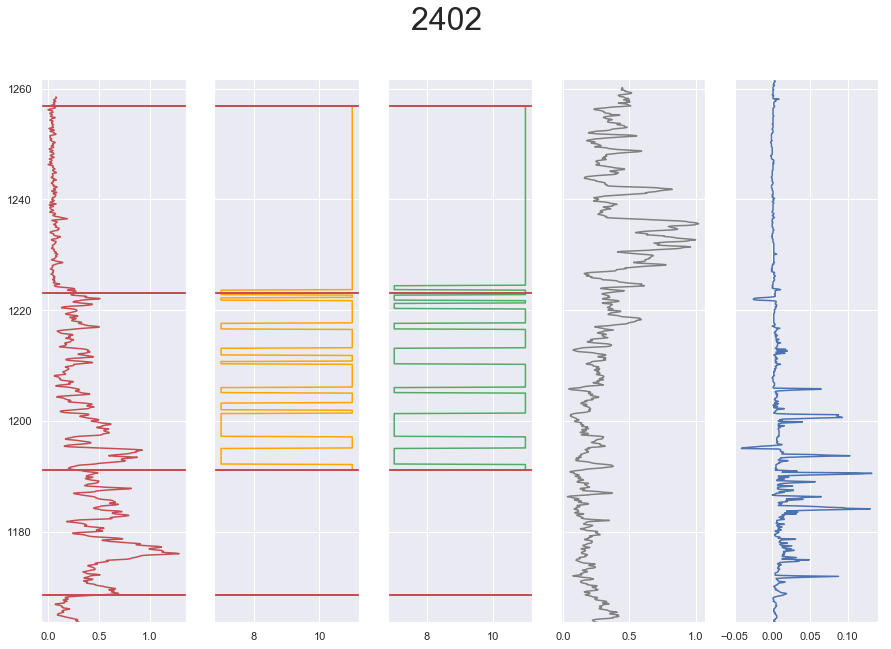

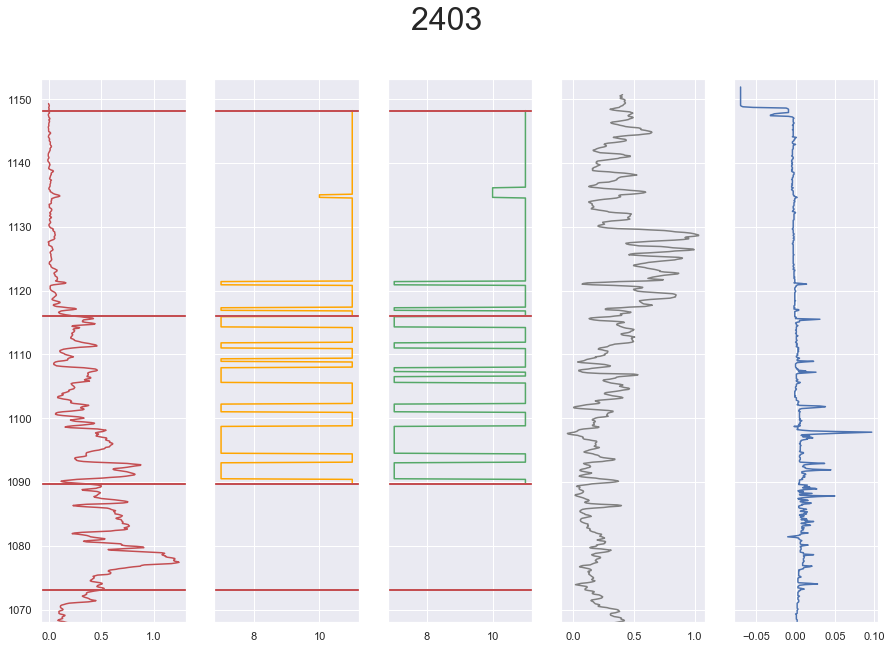


LEARN: 96.62 %


In [31]:
NVZ = np.array([])
for well in wells_test[:]:
    this_features, cur_Labels = get_feat_final(well.curves, well.CAND,well.tops)
    this_features = this_features.T
    real = well.curves['LITO_LEARN']
    DEPT = well.curves["DEPT"]
    ind = np.logical_and(np.abs(well.curves["DEPT"]) >= well.tops[0], np.abs(well.curves["DEPT"]) <= well.tops[3])

    lito_auto = np.ones(DEPT.shape)*np.nan
    result = clf.predict(this_features)

    #result = model.predict_classes(this_features)
    result = le.inverse_transform(result)
    cand = well.CAND
    for i in range(len(cand)):
        c = cand[i]
        lito_auto[c[0] : c[1]+1] = result[i]
    
    True_Sum = 0
    Sum = 0
    
    for i in range(len(real)):
        if np.isnan(real[i]) or np.isnan(lito_auto[i]):
            continue
        else:
            if abs(real[i] - lito_auto[i]) < 1e-3:
                True_Sum += 1 
            Sum += 1
    err_i = True_Sum / Sum
    NVZ = np.append(NVZ, err_i)
    ###################
    
    
    fig, f = plt.subplots(nrows = 1, ncols = 5, sharey = True, figsize = (15,10))
    f[0].invert_yaxis()
    plt.suptitle(well.name,size = 32)
    
    f[0].set_ylim(well.tops[0]-5, well.tops[3]+5)
    f[0].plot(well.curves['AG_auto'], well.curves["DEPT"], "r")
    f[1].plot(lito_auto, well.curves["DEPT"], "orange") 
    f[2].plot(real, well.curves["DEPT"], "g")
    f[3].plot(well.curves['ANG_auto'], well.curves["DEPT"], "gray")
    f[4].plot(well.curves['Cavern'], well.curves["DEPT"], "b")
    
    f[0].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[0], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[0], color = 'r', linewidth = 2)
   #
    f[0].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[1], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[1], color = 'r', linewidth = 2)
  ##
    f[0].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[2], color = 'r', linewidth = 2)
    
    
    f[0].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[1].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    f[2].axhline(y = well.tops[3], color = 'r', linewidth = 2)
    
    
    plt.show()
print()
S = round(np.nanmean(NVZ) * 100, 2)
print("LEARN:", S, "%")

In [ ]:
# Очистка памяти видеокарты
from numba import cuda
cuda.select_device(0)
cuda.close()